

# **Turbo Spin Echo (TSE) Sequence** 
---
**About:** This notebook creates a 2D multi-slice Turbo Spin Echo (TSE) MRI sequence using the `pypulseq` library. This sequence is for fast imaging. A 2D Fourier transform can be used to reconstruct images from this acquisition after the data is reordered due to phase encode shuffling. Slices are interleaved and sequential.

---
## Contents
1. Install & import packages
2. Set system limits and acquisition parameters
3. Calculate sequence components
4. Add building blocks to sequence 
5. Examine sequence 
6. Export sequence as .seq file 

# 1. Install & import packages
Pypulseq (https://github.com/imr-framework/pypulseq) is used to generate the .seq format file. See [1] in references for more information about the Pulseq specification. 

In [ ]:
!pip install git+https://github.com/imr-framework/pypulseq.git@master

  Cloning https://github.com/imr-framework/pypulseq.git (to revision dev) to /tmp/pip-req-build-pobymgpi
  Running command git clone -q https://github.com/imr-framework/pypulseq.git /tmp/pip-req-build-pobymgpi
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Created wheel for pypulseq: filename=pypulseq-1.2.0.post3-cp36-none-any.whl size=73258 sha256=8376827391e0fe9f9b95931e693e57d1af2fb673a98d10d16a31e10c35490ed4
  Stored in directory: /tmp/pip-ephem-wheel-cache-dvdix20l/wheels/18/dd/da/be52d6c4f99b9ccc0d8320b3862f73b03cf4e9a51c1299b008
Successfully built pypulseq


Pypulseq, numpy, and plotting functions are imported. 
**Run the following code cell twice** to eliminate errors.


In [ ]:
# Import functions
import copy 
from math import pi
import math
import warnings
import numpy as np
from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_duration import calc_duration
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trap_pulse import make_trapezoid
from pypulseq.opts import Opts
from pypulseq.calc_rf_center import calc_rf_center
from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from scipy.io import savemat

import matplotlib.pyplot as plt

# 2. Set system limits and acquisition parameters

  


  

## System limits & setup
System limits are specific to the MR scanner. The provided limits are 
compatible with a Siemens Prisma 3T scanner.  

In [ ]:
# Set system limits
ramp_time = 250e-6 # Ramp up/down time for all gradients where this is specified
system = Opts(max_grad=32, grad_unit='mT/m', max_slew=130,
                  slew_unit='T/m/s', rf_ringdown_time=100e-6, # changed from 30e-6
                  rf_dead_time=100e-6, adc_dead_time=20e-6)

# Initialize sequence
seq = Sequence(system)
# Set the gyromagnetic ratio constant for protons
GAMMA_BAR = 42.5775e6

## Acquisition parameters (geometry)
* All distance values are in meters 
* This sequences acquires slices in the order they are listed; slice_locs indicate the slice locations relative to isocenter on the slice-selecting axis 

In [ ]:
# FOV, matrix size
fov = 0.250  # in meters
n = 32  # matrix size isotropic 

# Spatial encoding directions
ch_ro = 'x'
ch_pe = 'y'
ch_ss = 'z'

# Slice selection (meters)
n_slices = 1
thk = 5e-3 

# Derived parameters
Nf, Np = (n, n)
delta_k = 1 / fov
k_width = Nf * delta_k

# Slice locations (for default, set slice_locations to None)
gap = 5e-3
L = (n_slices-1)*(thk+gap)
displacement = 5e-3
acr_sl_locs = displacement + np.arange(-L/2, L/2 + thk + gap, thk + gap)
#print(acr_sl_locs)

slice_locations = [0]


## Acquisition parameters (contrast)
* Set flip angle (FA), inversion time (TI), repetition time (TR), and echo time (TE) here to set the target contrast


In [ ]:
# Number of echoes per excitation (i.e. turbo factor)
n_echo = 4
# Flip angle 
fa = 90  #degrees
# Timing (s)
TR = 2000e-3 # Repetition time
TE = 50e-3 # Echo time


## Acquisition parameters (others)





In [ ]:
# Readout duration 
readout_time = 6.4e-3 + 2 * system.adc_dead_time

# Excitation pulse duration
t_ex = 2.5e-3
t_exwd = t_ex + system.rf_ringdown_time + system.rf_dead_time

# Refocusing pulse duration 
t_ref = 2e-3
t_refwd = t_ref + system.rf_ringdown_time + system.rf_dead_time

# Time gaps for spoilers   
t_sp = 0.5 * (TE - readout_time - t_refwd) # time gap between pi-pulse and readout
t_spex = 0.5 * (TE - t_exwd - t_refwd) # time gap between pi/2-pulse and pi-pulse

# Spoiling factors
fsp_r = 1 # in readout direction per refocusing
fsp_s = 0.5 # in slice direction per refocusing 


# 3. Calculate sequence components



## Slice-selective RF pulses & gradient
* RF pulses with zero frequency shift are created. The frequency is then changed before adding the pulses to sequence blocks for each slice.
* Two unique RF pulses are generated: 
  - $\alpha$-pulse (flip into x-y plane) 
  - 180-degree pulse (refocusing) 
 
 

In [ ]:

# 90 deg pulse (+y')
rf_ex_phase = np.pi / 2
flip_ex = fa * np.pi / 180
rf_ex, g_ss, _ = make_sinc_pulse(flip_angle=flip_ex, system=system, duration=t_ex, slice_thickness=thk,
                               apodization=0.5, time_bw_product=4, phase_offset=rf_ex_phase)
gs_ex = make_trapezoid(channel=ch_ss, system=system, amplitude=g_ss.amplitude, flat_time=t_exwd, rise_time=ramp_time)


# 180 deg pulse (+x')
rf_ref_phase = 0
flip_ref = 180 * np.pi / 180
rf_ref, gz, _ = make_sinc_pulse(flip_angle=flip_ref, system=system, duration=t_ref, slice_thickness=thk,
                                apodization=0.5, time_bw_product=4, phase_offset=rf_ref_phase, use='refocusing')
gs_ref = make_trapezoid(channel=ch_ss, system=system, amplitude=gs_ex.amplitude, flat_time=t_refwd, rise_time=ramp_time)


## Make gradients and ADC
* gs_spex : slice direction spoiler between initial excitation and 1st 180 pulse
* gs_spr : slice direction spoiler between 180 pulses 
* gr_spr : readout direction spoiler; area is (fsp_r) x (full readout area)


In [ ]:
# SS spoiling  
ags_ex = gs_ex.area / 2
gs_spr = make_trapezoid(channel=ch_ss, system=system, area=ags_ex * (1 + fsp_s), duration=t_sp, rise_time=ramp_time)
gs_spex = make_trapezoid(channel=ch_ss, system=system, area=ags_ex * fsp_s, duration=t_spex, rise_time=ramp_time)

# Readout gradient and ADC 
gr_acq = make_trapezoid(channel=ch_ro, system=system, flat_area=k_width, flat_time=readout_time, rise_time=ramp_time)

# No need for risetime delay since it is set at beginning of flattime; delay is ADC deadtime 
adc = make_adc(num_samples=Nf, duration=gr_acq.flat_time - 40e-6, delay=20e-6) 

# RO spoiling  
gr_spr = make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * fsp_r, duration=t_sp, rise_time=ramp_time)

# Following is not used anywhere
# gr_spex = make_trapezoid(channel=ch_ro, system=system, area=gr_acq.area * (1 + fsp_r), duration=t_spex, rise_time=ramp_time)


# Prephasing gradient in RO direction 
agr_preph = gr_acq.area / 2 + gr_spr.area
gr_preph = make_trapezoid(channel=ch_ro, system=system, area=agr_preph, duration=t_spex, rise_time=ramp_time)

## **Phase encoding areas** 
Need to export the pe_order for reconsturuction! 

In [ ]:
# Phase encoding lobe calculations
#import math
#import numpy as np 
#Ny = 8
#n_echo = 4
#delta_k = 0.1

# Number of readouts/echoes to be produced per TR 
n_ex = math.floor(Np / n_echo)
pe_steps = np.arange(1, n_echo * n_ex + 1) - 0.5 * n_echo * n_ex - 1
if divmod(n_echo, 2)[1] == 0: # If there is an even number of echoes 
    pe_steps = np.roll(pe_steps, -round(n_ex / 2))

pe_order = pe_steps.reshape((n_ex, n_echo), order='F').T

savemat('pe_info.mat',{'order': pe_order, 'dims': ['n_echo', 'n_ex']})

phase_areas = pe_order * delta_k

print(phase_areas)

[[-48. -44. -40. -36. -32. -28. -24. -20.]
 [-16. -12.  -8.  -4.   0.   4.   8.  12.]
 [ 16.  20.  24.  28.  32.  36.  40.  44.]
 [ 48.  52.  56.  60. -64. -60. -56. -52.]]


In [ ]:
print(n_echo)
print(Np)
print(n_ex)

4
32
8


## Split gradients

In [ ]:
# Split gradients and recombine into blocks

# gs1 : ramp up of gs_ex
gs1_times = [0, gs_ex.rise_time]
gs1_amp = [0, gs_ex.amplitude]
gs1 = make_extended_trapezoid(channel=ch_ss, times=gs1_times, amplitudes=gs1_amp)

# gs2 : flat part of gs_ex
gs2_times = [0, gs_ex.flat_time]
gs2_amp = [gs_ex.amplitude, gs_ex.amplitude]
gs2 = make_extended_trapezoid(channel=ch_ss, times=gs2_times, amplitudes=gs2_amp)

# gs3 : Bridged slice pre-spoiler 
gs3_times = [0, gs_spex.rise_time, gs_spex.rise_time + gs_spex.flat_time,
             gs_spex.rise_time + gs_spex.flat_time + gs_spex.fall_time]
gs3_amp = [gs_ex.amplitude, gs_spex.amplitude, gs_spex.amplitude, gs_ref.amplitude]
gs3 = make_extended_trapezoid(channel=ch_ss, times=gs3_times, amplitudes=gs3_amp)


# gs4 : Flat slice selector for pi-pulse 
gs4_times = [0, gs_ref.flat_time]
gs4_amp = [gs_ref.amplitude, gs_ref.amplitude]
gs4 = make_extended_trapezoid(channel=ch_ss, times=gs4_times, amplitudes=gs4_amp)

# gs5 : Bridged slice post-spoiler
gs5_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
             gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
gs5_amp = [gs_ref.amplitude, gs_spr.amplitude, gs_spr.amplitude, 0]
gs5 = make_extended_trapezoid(channel=ch_ss, times=gs5_times, amplitudes=gs5_amp)



# gs7 : The gs3 for next pi-pulse
gs7_times = [0, gs_spr.rise_time, gs_spr.rise_time + gs_spr.flat_time,
             gs_spr.rise_time + gs_spr.flat_time + gs_spr.fall_time]
gs7_amp = [0, gs_spr.amplitude, gs_spr.amplitude, gs_ref.amplitude]
gs7 = make_extended_trapezoid(channel=ch_ss, times=gs7_times, amplitudes=gs7_amp)


# gr3 : pre-readout gradient
gr3 = gr_preph


# gr5 : Readout post-spoiler 
gr5_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
             gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
gr5_amp = [0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude]
gr5 = make_extended_trapezoid(channel=ch_ro, times=gr5_times, amplitudes=gr5_amp)


# gr6 : Flat readout gradient 
gr6_times = [0, readout_time]
gr6_amp = [gr_acq.amplitude, gr_acq.amplitude]
gr6 = make_extended_trapezoid(channel=ch_ro, times=gr6_times, amplitudes=gr6_amp)


# gr7 : the gr3 for next repeat 
gr7_times = [0, gr_spr.rise_time, gr_spr.rise_time + gr_spr.flat_time,
             gr_spr.rise_time + gr_spr.flat_time + gr_spr.fall_time]
gr7_amp = [gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0]
gr7 = make_extended_trapezoid(channel=ch_ro, times=gr7_times, amplitudes=gr7_amp)

## Timing (delay) calculations

In [ ]:
# delay_TR : delay at the end of each TSE pulse train (i.e. each TR)
t_ex = gs1.t[-1] + gs2.t[-1] + gs3.t[-1]
t_ref = gs4.t[-1] + gs5.t[-1] + gs7.t[-1] + readout_time
t_end = gs4.t[-1] + gs5.t[-1]
TE_train = t_ex + n_echo * t_ref + t_end
TR_fill = (TR - n_slices * TE_train) / n_slices
TR_fill = system.grad_raster_time * round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(f'TR too short, adapted to include all slices to: {1000 * n_slices * (TE_train + TR_fill)} ms')
else:
    print(f'TR fill: {1000 * TR_fill} ms')
delay_TR = make_delay(TR_fill)



TR fill: 1751.7900000000002 ms


# 4. Add building blocks to sequence

In [ ]:
for k_ex in range(n_ex + 1): # For each TR  
    for s in range(n_slices): # For each slice (multislice)

        if slice_locations is None:
          rf_ex.freq_offset = gs_ex.amplitude * thk * (s - (n_slices - 1) / 2)
          rf_ref.freq_offset = gs_ref.amplitude * thk * (s - (n_slices - 1) / 2)
          rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * calc_rf_center(rf_ex)[0]
          rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * calc_rf_center(rf_ref)[0]
        else:
          rf_ex.freq_offset = gs_ex.amplitude * slice_locations[s]
          rf_ref.freq_offset = gs_ref.amplitude * slice_locations[s]
          rf_ex.phase_offset = rf_ex_phase - 2 * np.pi * rf_ex.freq_offset * calc_rf_center(rf_ex)[0]
          rf_ref.phase_offset = rf_ref_phase - 2 * np.pi * rf_ref.freq_offset * calc_rf_center(rf_ref)[0]
        
        seq.add_block(gs1)
        seq.add_block(gs2, rf_ex) # make sure gs2 has channel ch_ss
        seq.add_block(gs3, gr3)

        for k_echo in range(n_echo): # For each echo 
            if k_ex > 0:
                phase_area = phase_areas[k_echo, k_ex - 1]
            else:
                # First TR is skipped so zero phase encoding is needed
                phase_area = 0.0  # 0.0 and not 0 because -phase_area should successfully result in negative zero



            gp_pre = make_trapezoid(channel=ch_pe, system=system, area=phase_area, duration=t_sp, rise_time=ramp_time)
            print('gp_pre info: ', gp_pre)
            
            gp_rew = make_trapezoid(channel=ch_pe, system=system, area=-phase_area, duration=t_sp, rise_time=ramp_time)
            
            seq.add_block(gs4, rf_ref) 
            seq.add_block(gs5, gr5, gp_pre)
            
            # Skipping first TR 
            if k_ex > 0:
                seq.add_block(gr6, adc)
            else:
                seq.add_block(gr6)

            seq.add_block(gs7, gr7, gp_rew)

        seq.add_block(gs4)
        seq.add_block(gs5)
        seq.add_block(delay_TR)



gp_pre info:  namespace(amplitude=0.0, area=0.0, channel='y', delay=0, fall_time=0.00025, first=0, flat_area=0.0, flat_time=0.02018, last=0, rise_time=0.00025, type='trap')
gp_pre info:  namespace(amplitude=0.0, area=0.0, channel='y', delay=0, fall_time=0.00025, first=0, flat_area=0.0, flat_time=0.02018, last=0, rise_time=0.00025, type='trap')
gp_pre info:  namespace(amplitude=0.0, area=0.0, channel='y', delay=0, fall_time=0.00025, first=0, flat_area=0.0, flat_time=0.02018, last=0, rise_time=0.00025, type='trap')
gp_pre info:  namespace(amplitude=0.0, area=0.0, channel='y', delay=0, fall_time=0.00025, first=0, flat_area=0.0, flat_time=0.02018, last=0, rise_time=0.00025, type='trap')
gp_pre info:  namespace(amplitude=-2349.4860499265787, area=-48.00000000000001, channel='y', delay=0, fall_time=0.00025, first=0, flat_area=-47.41262848751836, flat_time=0.02018, last=0, rise_time=0.00025, type='trap')
gp_pre info:  namespace(amplitude=-783.1620166421928, area=-16.0, channel='y', delay=0, f

# 5. Examine sequence



## Plot sequence

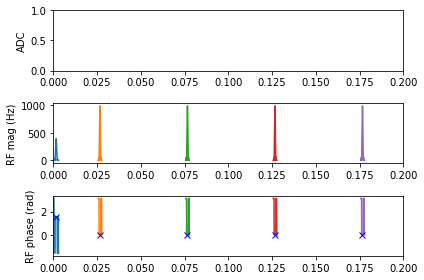

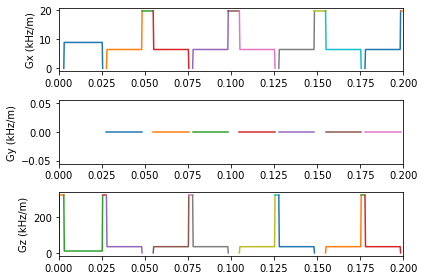

In [ ]:
# Use inbuilt seq.plot method to see all waveforms (RF pulses, Gx, Gy, Gz, ADC)
#plt.tight_layout() 
seq.plot(time_range=[0, 0.1*TR])

## Print sequence summary 
This cell generates a detailed header for the sequence. It takes about 3 minutes to run with the default parameters.


In [ ]:
print(seq.test_report())

KeyboardInterrupt: ignored

# 6. Export sequence as .seq file

THe following cell writes the sequence into a .seq file and initiates its download from the browser. 

In [ ]:
# Make copy of seq for writing to file
# The copy is needed because seq.write changes numerical data within the seq object for unit conversion  
#seq_name = f"irse_ms_N{n}_Ns{ns_per_TR}_TI{int(TI*1000)}_TE{int(TE*1000)}_TR{int(TR*1000)}_FA{int(fa)}deg_dwell-10us.seq"
seq_name = f"tse_ms_FOV{int(fov*1000)}mm_N{Nf}_Ns{n_slices}_TR{int(TR*1000)}ms_TE{int(TE*1000)}ms_{n_echo}echoes_dwell{adc.dwell*1e6}us.seq"
seq_to_write = copy.deepcopy(seq)
seq_to_write.write(seq_name)


from google.colab import files
# Upload local files to Colab VM
#uploaded = files.upload()
# Download Colab VM fiels to local
files.download(seq_name)
files.download('pe_info.mat')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References
1. Layton, K. J., Kroboth, S., Jia, F., Littin, S., Yu, H., Leupold, J., ... & Zaitsev, M. (2017). Pulseq: a rapid and hardware‐independent pulse sequence prototyping framework. Magnetic resonance in medicine, 77(4), 1544-1552.